<a id="imports"></a>
## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import geopandas
import numpy as np
import pickle
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from nltk.stem.porter import *
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from math import pi
from bokeh.io import output_notebook, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum

In [2]:
airlines = pd.read_csv('./data/with_sentiment.csv')

In [3]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5954 entries, 0 to 5953
Data columns (total 13 columns):
Unnamed: 0           5954 non-null int64
text                 5954 non-null object
tweet_coord          334 non-null object
tweet_created        5954 non-null object
tweet_location       4118 non-null object
negative             5954 non-null float64
positive             5954 non-null float64
neutral              5954 non-null float64
compound             5954 non-null float64
lemmatized           5954 non-null object
clean                5937 non-null object
blob_polarity        5954 non-null float64
blob_subjectivity    5954 non-null float64
dtypes: float64(6), int64(1), object(6)
memory usage: 604.8+ KB


## Tagging Based on Keywords

In [4]:
keyword_dict = {'compliment':['thank','thanks','thankyou','thx'],
                'staff':['staff','pilot','captain','agent','crew','supervisor','attendant','unprofessional',
                         'customerservice','badcustomerservice','learncustomerservice','customer service'],
                'delay':['delay','delayed','wait','waiting','stuck','slow','late'],
                'ticketing_billing':['ticket','tix','credit','charges','ticeting'],
                'baggage':['baggage','bag','break','suitcase','broke','luggage'],
                'refund':['refund','claim','reimburse'],
                'cancellation':['cancelled','cancellation'],
                'online':['website','webpage','app','dm'],
                'loyalty_program':['loyalty program','mileageplus','freqyent flyer program','mileage plus'],
                'connection':['connection'],
                'children':['child','children','kid','grandchild','grandson','granddaughter','son','daughter','infant','baby']}

In [5]:
airlines['keywords'] = ''

In [6]:
#tweets regarding compliments
thank_index = airlines[(airlines['lemmatized'].str.contains('thank',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('thanks',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('thx',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('thnx',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('thankyou',regex = False)== True)].index.tolist()

airlines.loc[thank_index,'keywords'] += [' compliment']

#tweets regarding staff
staff_index = airlines[(airlines['lemmatized'].str.contains('staff',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('pilot',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('captain',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('agent',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('crew',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('supervisor',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('attendant',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('unprofessional',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('customerservice',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('badcustomerservice',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('learncustomerservice',regex = False)== True)|
                       ((airlines['lemmatized'].str.contains('customer',regex = False)) & 
                        airlines['lemmatized'].str.contains('service',regex = False))].index.tolist()

airlines.loc[staff_index,'keywords'] += [' staff']

#tweets regarding delays
delay_index = airlines[(airlines['lemmatized'].str.contains('delay',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('delayed',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('wait',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('waiting',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('stuck',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('late',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('slow',regex = False)== True)].index.tolist()

airlines.loc[delay_index,'keywords'] += [' delay']

#tweets regarding ticketing & billing
ticketing_index = airlines[(airlines['lemmatized'].str.contains('ticket',regex = False)== True)|
                           (airlines['lemmatized'].str.contains('tix',regex = False)== True)|
                           (airlines['lemmatized'].str.contains('credit',regex = False)== True)|
                           (airlines['lemmatized'].str.contains('charges',regex = False)== True)|
                           (airlines['lemmatized'].str.contains('ticketing',regex = False)== True)].index.tolist()

airlines.loc[ticketing_index,'keywords'] += [' ticketing_billing']

#tweets regarding baggage
bag_index = airlines[(airlines['lemmatized'].str.contains('baggage',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('bag',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('break',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('suitcase',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('broke',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('luggage',regex = False)== True)].index.tolist()

airlines.loc[bag_index,'keywords'] += [' baggage']

#tweets regarding refunds
refund_index = airlines[(airlines['lemmatized'].str.contains('refund',regex = False)== True)|
                        (airlines['lemmatized'].str.contains('refunded',regex = False)== True)|
                        (airlines['lemmatized'].str.contains('claim',regex = False)== True)|
                        (airlines['lemmatized'].str.contains('reimburse',regex = False)== True)].index.tolist()

airlines.loc[refund_index,'keywords'] += [' refund']


#tweets regarding cancellation
cancel_index = airlines[(airlines['lemmatized'].str.contains('cancelled',regex = False)== True)|
                        (airlines['lemmatized'].str.contains('cancellation',regex = False)== True)].index.tolist()

airlines.loc[cancel_index,'keywords'] += [' cancellation']

#tweets regarding website or app
web_index = airlines[(airlines['lemmatized'].str.contains('website',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('webpage',regex = False)== True)|
                     (airlines['lemmatized'].str.contains(' app ',regex = False)== True)|
                     (airlines['lemmatized'].str.contains(' dm ',regex = False)== True)].index.tolist()

airlines.loc[web_index,'keywords'] += [' online']

#tweets regarding loyalty program
loyalty_index = airlines[(airlines['lemmatized'].str.contains('loyalty program',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('mileageplus',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('freqyent flyer program',regex = False)== True)|
                     (airlines['lemmatized'].str.contains('mileage',regex = False)== True)].index.tolist()

airlines.loc[loyalty_index,'keywords'] += [' loyalty_program']

#tweets regarding connections
connect_index = airlines[(airlines['lemmatized'].str.contains('connection',regex = False)== True)].index.tolist()

airlines.loc[connect_index,'keywords'] += [' connection']

#tweets regarding children
child_index = airlines[(airlines['lemmatized'].str.contains('child',regex = False)== True)|
                       (airlines['lemmatized'].str.contains(' kid ',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('boy',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('girl',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('infant',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('daughter',regex = False)== True)|
                       (airlines['lemmatized'].str.contains(' son ',regex = False)== True)|
                       (airlines['lemmatized'].str.contains('baby',regex = False)== True)].index.tolist()

airlines.loc[child_index,'keywords'] += [' children']

In [7]:
#checking the labelling
airlines[airlines['keywords']!=''].loc[0:100,['text','keywords']]

,text,keywords
0,thanks,compliment
1,Thanks for taking care of that MR Happy customer,compliment
2,still no refund or word via DM Please resolve this issue as your Cancelled Flightled flight was useless to my assistants trip,refund cancellation
3,Delayed due to lack of crew and now delayed again because theres a long line for deicing Still need to improve service united,staff delay
4,thanks we filled it out Hows our luck with this Is it common,compliment
5,Your ERIORD express connections are hugely popular now if only we could have an ERIEWR hop,connection
9,Gate agent hooked me up with alternate flights If you have a way to PREVENT the constant issues that would rock,staff
11,Thanks It is on the same ticket,compliment ticketing_billing
13,is the worst Nonrefundable First class tickets Oh because when you select GlobalFC their system auto selects economy wupgrade,ticketing_billing refund
14,So I can buy tix 3 days before flight but cant transfer the tix Flawed security logic Flawed customer service,staff ticketing_billing


In [8]:
keyword_count = {}
for key in keyword_dict.keys():
    keyword_count.update({key : airlines.loc[:,'keywords'][airlines.loc[:,'keywords'].str.contains(key,regex=False)].count()})
    
keyword_count

{'compliment': 493,
 'staff': 692,
 'delay': 810,
 'ticketing_billing': 203,
 'baggage': 551,
 'refund': 148,
 'cancellation': 268,
 'online': 37,
 'loyalty_program': 47,
 'connection': 93,
 'children': 98}

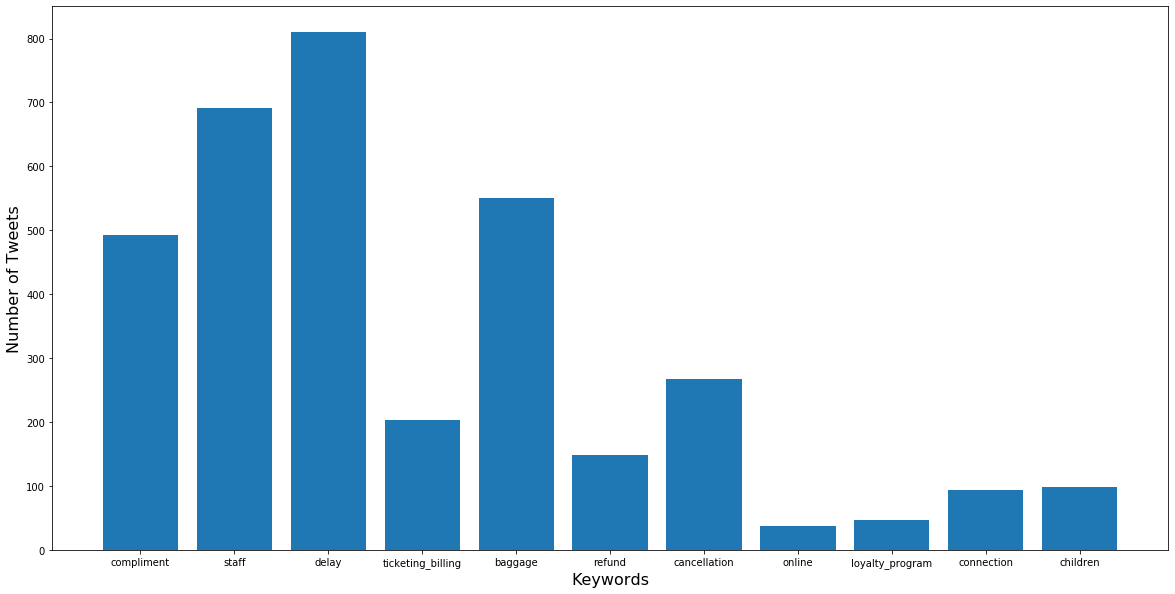

In [9]:
plt.figure(figsize=(20,10))
plt.bar(list(keyword_count.keys()), keyword_count.values())
plt.xlabel('Keywords', fontsize=16)
plt.ylabel('Number of Tweets', fontsize=16)
plt.savefig('website/static/images/keywords_train.png')
plt.show()

In [10]:
output_notebook()

x = {
'compliment': 493,
 'staff': 692,
 'delay': 810,
 'ticketing_billing': 203,
 'baggage': 551,
 'refund': 148,
 'cancellation': 268,
 'online': 37,
 'loyalty_program': 47,
 'connection': 93,
 'children': 98
}

data = pd.Series(x).reset_index(name='value').rename(columns={'index':'keyword'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Category20c[len(x)]
data['percentage'] = data['value']/data['value'].sum()*100

p = figure(plot_width=550,plot_height=500, title="Keywords", toolbar_location=None,
           tools="hover", tooltips="@keyword: @percentage{0.2f}%", x_range=(-0.5, 1.0))

p.wedge(x=0, y=0, radius=0.45,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='keyword', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

Loading BokehJS ...

In [11]:
airlines['keywords'].value_counts()[1:21]

 delay                 463
 staff                 397
 compliment            328
 baggage               305
 cancellation          146
 ticketing_billing     121
 staff delay           96 
 children              64 
 delay baggage         62 
 refund                49 
 connection            46 
 compliment staff      41 
 staff baggage         37 
 delay cancellation    34 
 compliment baggage    31 
 baggage refund        30 
 compliment delay      30 
 loyalty_program       27 
 delay connection      24 
 online                22 
Name: keywords, dtype: int64

In [12]:
airlines.fillna(value='',inplace=True)

In [13]:
#showing tweets with identified keywords
airlines_keyworded = airlines[airlines['keywords']!='']
airlines_not_keyworded = airlines[airlines['keywords']=='']

airlines_keyworded.to_csv('./data/airlines_keyworded.csv')

In [14]:
# Indicies of each class' observations
staff = airlines_keyworded[airlines_keyworded['keywords']==' staff']
compliment = airlines_keyworded[airlines_keyworded['keywords']==' compliment']
delay = airlines_keyworded[airlines_keyworded['keywords']==' delay']
baggage = airlines_keyworded[airlines_keyworded['keywords']==' baggage']
refund = airlines_keyworded[airlines_keyworded['keywords']==' refund']
cancellation = airlines_keyworded[airlines_keyworded['keywords']==' cancellation']
online = airlines_keyworded[airlines_keyworded['keywords']==' online']
loyalty_program = airlines_keyworded[airlines_keyworded['keywords']==' loyalty_program']
connection = airlines_keyworded[airlines_keyworded['keywords']==' connection']
children = airlines_keyworded[airlines_keyworded['keywords']==' children']
ticketing_billing = airlines_keyworded[airlines_keyworded['keywords']==' ticketing_billing']

In [15]:
staff = resample(staff, replace=True, n_samples=400, random_state=42)
compliment = resample(compliment, replace=True, n_samples=400, random_state=42)
delay = resample(delay, replace=False, n_samples=400, random_state=42)
ticketing_billing = resample(ticketing_billing, replace=True, n_samples=400, random_state=42)
baggage = resample(baggage, replace=True, n_samples=400, random_state=42)
refund = resample(refund, replace=True, n_samples=400, random_state=42)
cancellation = resample(cancellation, replace=True, n_samples=400, random_state=42)
online = resample(online, replace=True, n_samples=400, random_state=42)
loyalty_program = resample(loyalty_program, replace=True, n_samples=400, random_state=42)
connection = resample(connection, replace=True, n_samples=400, random_state=42)
children = resample(children, replace=True, n_samples=400, random_state=42)

In [16]:
keywords_resampled = pd.concat([staff,compliment,delay,ticketing_billing,baggage,refund,cancellation,online,loyalty_program,connection,children])
keywords_resampled['keywords'].value_counts()

 refund               400
 loyalty_program      400
 staff                400
 ticketing_billing    400
 cancellation         400
 children             400
 baggage              400
 compliment           400
 online               400
 delay                400
 connection           400
Name: keywords, dtype: int64

In [17]:
X = keywords_resampled['clean']
y = keywords_resampled['keywords']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, test_size = 0.3)

In [18]:
# using count vectorizer and logistic regression
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='liblinear'))
])

In [26]:
pipe_params = {
    'cvec__max_features': [200,300,400],
    'cvec__min_df': [0.01,0.02,0.03],
    'cvec__max_df': [.1,.2,.3],
    'cvec__ngram_range': [(1,1), (1,2),(1,3)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params,cv=3,n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9435064935064935


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'cvec__max_df': 0.1,
 'cvec__max_features': 300,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2)}

In [20]:
gs.score(X_train,y_train)

0.9655844155844155

In [21]:
gs.score(X_test,y_test)

0.9424242424242424

In [22]:
pickle.dump(gs, open("website/static/pickle/model.pkl", "wb"))

In [25]:
#predict and display newly labelled tweets
airlines_not_keyworded.loc[:,'predicted'] = gs.predict(airlines_not_keyworded.loc[:,'clean'])
airlines_not_keyworded.loc[100:200,['text','clean','predicted']]

,text,clean,predicted
105,crashed trying to check in,crashed trying check,staff
106,Wow What a deal Again 30 plus seats available Easy change to make a customer happy,wow deal plus seat available easy change make customer happy,staff
112,is there an email address I can reach Too long for a DM,email address reach long dm,ticketing_billing
120,So do I need to book two one ways in order for her to fly as an unaccompanied minor,need book two one way order fly unaccompanied minor,staff
122,youll need to upgrade the seats too even in economy plus its like sitting on a concrete bench,youll need upgrade seat even economy plus like sitting concrete bench,baggage
124,bet you wont honour them like mine ey,bet wont honour like mine ey,baggage
126,I guess thats too much ask huh,guess thats much ask huh,compliment
127,but its hard to stay upset at someone when they at least TRY to show remorse,hard stay upset someone least try show remorse,staff
128,By the way a simple apology goes a long way even if its a hollow one Its obvious that you dont care about me or my wellbeing,way simple apology go long way even hollow one obvious dont care wellbeing,staff
129,This isnt a one time thing either Its a shocking pattern of repeated neglect and disrespect,isnt one time thing either shocking pattern repeated neglect disrespect,staff


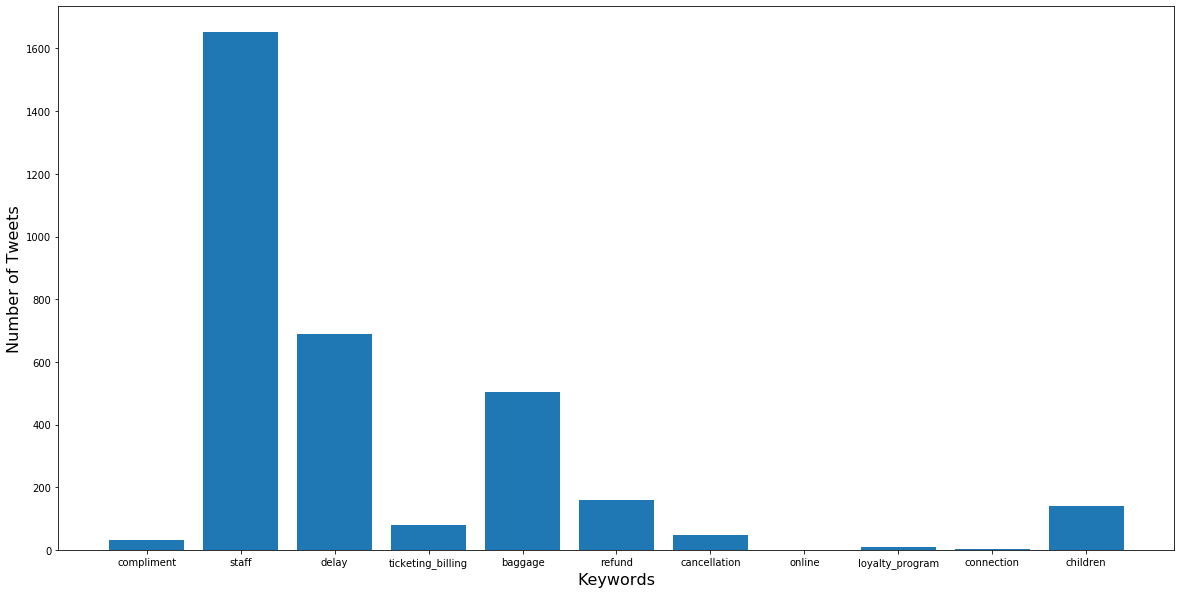

In [24]:
keyword_count = {}
for key in keyword_dict.keys():
    keyword_count.update({key : airlines_not_keyworded.loc[:,'predicted'][airlines_not_keyworded.loc[:,'predicted'].str.contains(key,regex=False)].count()})

plt.figure(figsize=(20,10))
plt.bar(list(keyword_count.keys()), keyword_count.values())
plt.xlabel('Keywords', fontsize=16)
plt.ylabel('Number of Tweets', fontsize=16)
plt.savefig('website/static/images/keywords_test.png')
plt.show()